# Managing Big Data with Pyspark + Machine Learning Model Development

In [ ]:
import pyspark
from pyspark.sql import SparkSession

spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext.setLogLevel('ERROR')

# High-Cost Patient Prediction Model

For this project, I combined data from multiple large datasets and calculated the total count of encounters, devices, immunzations, and imaging studies (including duplicates) for each patient as well as the total unique number of conditions and medications (excluding duplicates) for each patient. I also acquired all numeric data from the observation data set (labs, vitals, quality of life metrics, biometrics, etc) and calcualted the average for each patient. Missing observation data were imputed with an average value. I then combined each of these dataframes with the patient dataset to include demographic information in the final machine learning model.

For machine learning model development, I first prepared the data by indexing and encoding string values, removing unnecessary columns, and using vector assembler to combine all features into a single column. 

I developed two ML models (Random Forest and Gradient Boosted Trees) as well as a logistic regression model for baseline comparison. To evaluate the models, I used AUROC.

In [12]:
#load patient data and preview
patient_data = spark.read.csv('./patients.csv', header = True, sep = ',', inferSchema= True)

patient_data.show(5)

+--------------------+---------+---------+------+------+-------+-----+-----------+------+--------------------+----------+--------+-----------------+-------------------+-------------------+
|                  Id|BIRTHDATE|DEATHDATE|PREFIX|SUFFIX|MARITAL| RACE|  ETHNICITY|GENDER|          BIRTHPLACE|      CITY|   STATE|           COUNTY|HEALTHCARE_EXPENSES|HEALTHCARE_COVERAGE|
+--------------------+---------+---------+------+------+-------+-----+-----------+------+--------------------+----------+--------+-----------------+-------------------+-------------------+
|f1639046-ecb1-b40...|  8/31/57|     NULL|   Ms.|  NULL|      S|white|nonhispanic|     F|Germantown  Maryl...| Baltimore|Maryland|   Baltimore city|           59484.51|            1455.08|
|f851859f-b0fe-8b3...| 11/22/50|     NULL|  Mrs.|  NULL|      M|black|nonhispanic|     F|Clarksburg  Maryl...| Baltimore|Maryland|   Baltimore city|          239428.05|           12764.06|
|00e22b7e-70ae-e92...| 10/24/53|  7/12/19|   Mr.|  NULL

## Get counts for all pertient data sets

### Conditions

In [13]:
#load conditions and preview data

conditions_data = spark.read.csv('./conditions.csv', header = True, sep=',', inferSchema=True)

conditions_data.show(5)

+----------+----+--------------------+--------------------+---------+--------------------+
|     START|STOP|             PATIENT|           ENCOUNTER|     CODE|         DESCRIPTION|
+----------+----+--------------------+--------------------+---------+--------------------+
|1973-12-22|NULL|f1639046-ecb1-b40...|47a338d3-4e76-fdf...| 19169002|Miscarriage in fi...|
|1992-12-02|NULL|f851859f-b0fe-8b3...|ed3e50dd-ebdf-eae...|162864005|Body mass index 3...|
|1996-12-11|NULL|f851859f-b0fe-8b3...|e56964f0-e8a2-816...| 44054006|            Diabetes|
|1996-12-11|NULL|f851859f-b0fe-8b3...|e56964f0-e8a2-816...| 59621000|        Hypertension|
|1994-11-19|NULL|f1639046-ecb1-b40...|940f5276-8893-2ee...|162864005|Body mass index 3...|
+----------+----+--------------------+--------------------+---------+--------------------+
only showing top 5 rows



In [14]:
#count unique conditions per patient (to acquire the total number of unique conditions for each patient)
from pyspark.sql.functions import countDistinct

conditions_count = conditions_data.groupby('PATIENT').agg(countDistinct('CODE')).withColumnRenamed('count(DISTINCT CODE)', 'conditions_count')

conditions_count.sort('conditions_count',ascending = False).show(10)

+--------------------+----------------+
|             PATIENT|conditions_count|
+--------------------+----------------+
|dc1e507b-d2ba-e38...|              49|
|99481683-7c2f-9cc...|              47|
|b3915e7a-48f4-a4e...|              46|
|bcb2fa11-f14a-3e3...|              46|
|073bf64a-a95e-48d...|              46|
|45552201-c424-fbe...|              46|
|248174ec-9941-e47...|              43|
|fac9f918-e773-99c...|              43|
|e37f212c-a1fe-1e8...|              42|
|514e7264-f7a8-2a9...|              42|
+--------------------+----------------+
only showing top 10 rows



### Devices

In [15]:
#load devices and preview data
devices_data = spark.read.csv('./devices.csv', header = True, sep = ',', inferSchema=True)

devices_data.show(5)

+-------------------+-------------------+--------------------+--------------------+---------+--------------------+--------------------+
|              START|               STOP|             PATIENT|           ENCOUNTER|     CODE|         DESCRIPTION|                 UDI|
+-------------------+-------------------+--------------------+--------------------+---------+--------------------+--------------------+
|2019-06-28 14:45:09|               NULL|bc7d25d5-4bf2-2fa...|d69019c5-9d3a-946...|706004007|Implantable cardi...|(01)5932536829855...|
|1967-10-10 10:00:03|               NULL|f4327619-e53f-982...|18eb7c0c-dbe5-d46...| 72506001|Implantable defib...|(01)8747437330701...|
|1967-05-01 13:21:37|               NULL|9e496462-1cb4-078...|ebe2f1fa-bd33-3bf...| 72506001|Implantable defib...|(01)3987268818848...|
|2020-03-25 08:52:03|2020-03-28 10:29:57|00665eb3-6f63-663...|52c637f2-15b7-418...|449071006|Mechanical ventil...|(01)3047376917047...|
|2020-03-25 08:52:03|2020-03-25 09:21:02|00665eb

In [16]:
#count number of devices per patient (not unique since we want to count each implantation)
devices_count = devices_data.groupby('PATIENT').count().withColumnRenamed('count', 'devices_count')

devices_count.sort('devices_count', ascending = False).show(10)

+--------------------+-------------+
|             PATIENT|devices_count|
+--------------------+-------------+
|7712a5d1-7327-f5c...|           15|
|013be217-6dfa-609...|           15|
|8cc200f2-2bb9-837...|           15|
|69d1c09c-e281-4bd...|           14|
|0087b7cb-ea89-9b9...|           14|
|62038bac-c261-5f9...|           14|
|5902f943-6620-6ec...|           14|
|e6867f29-3e40-6ba...|           14|
|0295a4ef-8c15-8e7...|           14|
|f4424612-e076-224...|           14|
+--------------------+-------------+
only showing top 10 rows



### Encounters

In [17]:
#load and preview encounter data
encounter_data = spark.read.csv('./encounters.csv', header=True, sep=',', inferSchema=True)

encounter_data.show(5)

+--------------------+-------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------+---------+--------------------+-------------------+----------------+--------------+----------+-----------------+
|                  Id|              START|               STOP|             PATIENT|        ORGANIZATION|            PROVIDER|               PAYER|ENCOUNTERCLASS|     CODE|         DESCRIPTION|BASE_ENCOUNTER_COST|TOTAL_CLAIM_COST|PAYER_COVERAGE|REASONCODE|REASONDESCRIPTION|
+--------------------+-------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------+---------+--------------------+-------------------+----------------+--------------+----------+-----------------+
|ed3e50dd-ebdf-eae...|1992-12-02 20:59:42|1992-12-02 21:14:42|f851859f-b0fe-8b3...|bcc122cf-e92a-360...|21141862-4f4e-3e3...|7c4411ce-02f1-39b...|      wellness|162673000|General

In [18]:
#count total encounters by encounter type per patient (using count distinct since encounter class is a separate column)
from pyspark.sql.functions import sum, col
encounter_count = encounter_data.groupby('PATIENT', 'EncounterClass').agg(countDistinct('Code')).withColumnRenamed('count(DISTINCT CODE)', 'encounter_count')

encounter_count.show(5)

+--------------------+--------------+---------------+
|             PATIENT|EncounterClass|encounter_count|
+--------------------+--------------+---------------+
|4bcfc7fa-94c5-f87...|     emergency|              2|
|94e7aa8e-1804-d0e...|    outpatient|              3|
|55ae0253-231a-bac...|      wellness|              2|
|4386c312-eb31-f7f...|    ambulatory|              5|
|ebe571c2-e293-327...|     inpatient|              1|
+--------------------+--------------+---------------+
only showing top 5 rows



In [19]:
#pivot table into wide data format
encounter_count_pivot = (encounter_count.groupby('PATIENT').pivot('EncounterClass').sum('encounter_count'))

encounter_count_pivot.show(5)

+--------------------+----------+---------+---------+----------+----------+--------+
|             PATIENT|ambulatory|emergency|inpatient|outpatient|urgentcare|wellness|
+--------------------+----------+---------+---------+----------+----------+--------+
|31117dd0-4822-770...|         3|        2|     NULL|         1|      NULL|       2|
|2e4a15bf-9aad-6f4...|         3|        1|     NULL|         1|         1|       1|
|f52c0bf4-8e32-20e...|         3|        1|     NULL|         1|      NULL|       1|
|cb75fe0b-d218-395...|         7|        2|        1|         2|         1|       2|
|11400b12-7297-3c6...|         1|        1|     NULL|      NULL|      NULL|       3|
+--------------------+----------+---------+---------+----------+----------+--------+
only showing top 5 rows



In [20]:
#fill NA values with 0
encounter_count_pivot = encounter_count_pivot.fillna(0)

#rename columns using dictionary / for loop strategy
col_name_list = {'ambulatory':'ambulatory_visits', 
                 'emergency':'emergency_visits', 
                 'inpatient':'inpatient_visits', 
                 'outpatient':'outpatient_visits', 
                 'urgentcare':'urgentcare_visits',
                 'wellness':'wellness_visits'}
for old_col,new_col in col_name_list.items():
    encounter_count_pivot = encounter_count_pivot.withColumnRenamed(old_col,new_col)

#calculate total encounters and save as new column
encounter_count_pivot = encounter_count_pivot.withColumn('total_visits', 
                                                         col('ambulatory_visits')+
                                                         col('emergency_visits')+
                                                         col('inpatient_visits')+
                                                         col('outpatient_visits')+
                                                         col('urgentcare_visits')+
                                                         col('wellness_visits')
                                                         )

encounter_count_pivot.show(10)

+--------------------+-----------------+----------------+----------------+-----------------+-----------------+---------------+------------+
|             PATIENT|ambulatory_visits|emergency_visits|inpatient_visits|outpatient_visits|urgentcare_visits|wellness_visits|total_visits|
+--------------------+-----------------+----------------+----------------+-----------------+-----------------+---------------+------------+
|31117dd0-4822-770...|                3|               2|               0|                1|                0|              2|           8|
|2e4a15bf-9aad-6f4...|                3|               1|               0|                1|                1|              1|           7|
|f52c0bf4-8e32-20e...|                3|               1|               0|                1|                0|              1|           6|
|cb75fe0b-d218-395...|                7|               2|               1|                2|                1|              2|          15|
|11400b12-7297-3c6..

### Imaging

In [21]:
#load imaging data and preview
imaging_data = spark.read.csv('./imaging_studies.csv', header = True, sep = ',', inferSchema=True)

imaging_data.show(5)

+--------------------+-------------------+--------------------+--------------------+--------------------+-------------+--------------------+-------------+--------------------+--------------------+--------------------+--------------------+--------------+
|                  Id|               DATE|             PATIENT|           ENCOUNTER|          SERIES_UID|BODYSITE_CODE|BODYSITE_DESCRIPTION|MODALITY_CODE|MODALITY_DESCRIPTION|        INSTANCE_UID|            SOP_CODE|     SOP_DESCRIPTION|PROCEDURE_CODE|
+--------------------+-------------------+--------------------+--------------------+--------------------+-------------+--------------------+-------------+--------------------+--------------------+--------------------+--------------------+--------------+
|e57fd778-f8c9-288...|2017-06-20 07:58:50|00e22b7e-70ae-e92...|2f631041-1db4-c4f...|1.2.840.99999999....|     51185008|Thoracic structur...|           CR|Computed Radiography|1.2.840.99999999....|1.2.840.10008.5.1...|Digital X-Ray Ima...|

In [22]:
#count total number of imaging studies per patient (using countdistinct to account for duplicate image instances but not duplicate image types)
imaging_count = imaging_data.groupby('PATIENT').agg(countDistinct('Id')).withColumnRenamed('count(DISTINCT Id)', 'imaging_count')

imaging_count.sort('imaging_count', ascending = False).show(10)

+--------------------+-------------+
|             PATIENT|imaging_count|
+--------------------+-------------+
|215958a4-2d73-bfb...|           91|
|f2ce6d94-9e60-54d...|           89|
|9529ea99-eb20-155...|           88|
|03969c2d-320f-06f...|           88|
|16d481aa-6e12-462...|           88|
|0672f778-ef2a-ab6...|           87|
|e626dc19-8754-351...|           86|
|c1b5369a-8dc3-50f...|           86|
|d49886a1-261f-33a...|           86|
|65a172bb-3fd5-246...|           86|
+--------------------+-------------+
only showing top 10 rows



### Immunizations

In [23]:
#load immunization data and preview
vax_data = spark.read.csv('./immunizations.csv', header = True, sep = ',', inferSchema=True)

vax_data.show(5)


+-------------------+--------------------+--------------------+----+--------------------+---------+
|               DATE|             PATIENT|           ENCOUNTER|CODE|         DESCRIPTION|BASE_COST|
+-------------------+--------------------+--------------------+----+--------------------+---------+
|2011-09-24 04:24:08|f1639046-ecb1-b40...|eae66f34-dedb-5d5...| 140|Influenza  season...|   126.73|
|2012-09-29 04:24:08|f1639046-ecb1-b40...|4d5a3d2b-9811-b05...| 140|Influenza  season...|   126.73|
|2013-10-05 04:24:08|f1639046-ecb1-b40...|6f0542c8-725e-9dd...| 140|Influenza  season...|   126.73|
|2012-03-07 20:59:42|f851859f-b0fe-8b3...|e822bfcc-def8-43f...| 140|Influenza  season...|   126.73|
|2012-03-07 20:59:42|f851859f-b0fe-8b3...|e822bfcc-def8-43f...| 113|Td (adult) preser...|   126.73|
+-------------------+--------------------+--------------------+----+--------------------+---------+
only showing top 5 rows



In [24]:
#count total vaccinations a patient recieved over lifetime (including duplicates)
vax_count = vax_data.groupBy('PATIENT').count().withColumnRenamed('count', 'immunization_count')

vax_count.sort('immunization_count',ascending = False).show(10)

+--------------------+------------------+
|             PATIENT|immunization_count|
+--------------------+------------------+
|9b7bd49f-c772-924...|                16|
|a891cf76-fa32-79f...|                16|
|c68edb6e-f71e-ab3...|                16|
|0229ae7d-eb71-3f0...|                15|
|73e5b7ad-bfb2-d36...|                15|
|98f918a3-807b-0bc...|                15|
|acdc063c-2f62-df6...|                15|
|66370dcd-dc76-d3d...|                15|
|bc6f58f6-fb53-205...|                15|
|c82eaebf-c933-3c7...|                15|
+--------------------+------------------+
only showing top 10 rows



### Medications

In [25]:
#load and preview med data
med_data = spark.read.csv('./medications.csv', header = True, sep =',', inferSchema=True)

med_data.show(5)

+-------------------+-------------------+--------------------+--------------------+--------------------+------+--------------------+---------+--------------+---------+---------+----------+-----------------+
|              START|               STOP|             PATIENT|               PAYER|           ENCOUNTER|  CODE|         DESCRIPTION|BASE_COST|PAYER_COVERAGE|DISPENSES|TOTALCOST|REASONCODE|REASONDESCRIPTION|
+-------------------+-------------------+--------------------+--------------------+--------------------+------+--------------------+---------+--------------+---------+---------+----------+-----------------+
|1996-12-11 20:59:42|1996-12-11 20:59:42|f851859f-b0fe-8b3...|7c4411ce-02f1-39b...|e56964f0-e8a2-816...|860975|24 HR Metformin h...|     6.59|           0.0|        1|     6.59|  44054006|         Diabetes|
|1996-12-11 20:59:42|1997-12-17 20:59:42|f851859f-b0fe-8b3...|7c4411ce-02f1-39b...|e56964f0-e8a2-816...|860975|24 HR Metformin h...|    43.55|           0.0|       12|    5

In [26]:
#count unique meds per patient (excluding duplicates to capture total number of unique medications prescribed to a patient over the data collection time period, not the total number of medications filled)
med_count = med_data.groupBy('PATIENT').agg(countDistinct('CODE')).withColumnRenamed('count(DISTINCT CODE)', 'med_count')

med_count.sort('med_count',ascending = False).show(10)

+--------------------+---------+
|             PATIENT|med_count|
+--------------------+---------+
|790611bf-1c4d-ae7...|       34|
|5c288719-42a2-06f...|       31|
|2596ca08-0e19-c70...|       31|
|4f291f32-e29e-cf8...|       30|
|17ce562a-87e9-eed...|       29|
|f6a038d4-6e84-7a3...|       29|
|e6867f29-3e40-6ba...|       29|
|07c609a9-31df-35f...|       28|
|dc1e507b-d2ba-e38...|       28|
|b2a77f6c-04cc-f3e...|       28|
+--------------------+---------+
only showing top 10 rows



### Observations (Labs/Vitals/Biometrics/Assessments)

In [27]:
#load and preview data

obs_data = spark.read.csv('./observations.csv', header = True, sep = ',', inferSchema = True)

obs_data.show(10)

+-------------------+--------------------+--------------------+-------+--------------------+-----+-------+-------+
|               DATE|             PATIENT|           ENCOUNTER|   CODE|         DESCRIPTION|VALUE|  UNITS|   TYPE|
+-------------------+--------------------+--------------------+-------+--------------------+-----+-------+-------+
|2012-03-07 20:59:42|f851859f-b0fe-8b3...|e822bfcc-def8-43f...| 8302-2|         Body Height|164.5|     cm|numeric|
|2011-09-24 04:24:08|f1639046-ecb1-b40...|eae66f34-dedb-5d5...| 8302-2|         Body Height|160.3|     cm|numeric|
|2012-03-07 20:59:42|f851859f-b0fe-8b3...|e822bfcc-def8-43f...|72514-3|Pain severity - 0...|  3.0|{score}|numeric|
|2011-09-24 04:24:08|f1639046-ecb1-b40...|eae66f34-dedb-5d5...|72514-3|Pain severity - 0...|  0.0|{score}|numeric|
|2012-03-07 20:59:42|f851859f-b0fe-8b3...|e822bfcc-def8-43f...|29463-7|         Body Weight| 80.8|     kg|numeric|
|2012-03-07 20:59:42|f851859f-b0fe-8b3...|e822bfcc-def8-43f...|39156-5|     Body

In [28]:
#claculate average for each observation per patient (will get null values for strings and remove later since we are only interested in numeric data)
from pyspark.sql.functions import avg

obs_values = obs_data.groupby('PATIENT', 'DESCRIPTION').agg(avg('VALUE'))

obs_values.show(10)

+--------------------+--------------------+------------------+
|             PATIENT|         DESCRIPTION|        avg(VALUE)|
+--------------------+--------------------+------------------+
|f1639046-ecb1-b40...|          Creatinine|              0.86|
|bc7d25d5-4bf2-2fa...|Aspartate aminotr...|18.756521739130434|
|56211549-b840-4b4...|    Body temperature|39.418749999999996|
|9e496462-1cb4-078...|Parainfluenza vir...|              NULL|
|a17ef1cb-e502-f2c...|              Sodium|            140.87|
|b2426284-baa2-9d0...|Iron saturation [...|29.924999999999997|
|00665eb3-6f63-663...|Alkaline phosphat...| 69.52222222222223|
|00665eb3-6f63-663...|Lactate dehydroge...|251.35454545454547|
|4025fce8-074c-2a9...|High Density Lipo...| 62.19230769230769|
|7ddaf492-632f-fad...|Systolic Blood Pr...|             122.0|
+--------------------+--------------------+------------------+
only showing top 10 rows



In [29]:
#print list of all values in 'DESCRIPTION' column to identify columns of interest
obs_values.select('DESCRIPTION').distinct().collect()

[Row(DESCRIPTION='Hematocrit'),
 Row(DESCRIPTION='Symptoms score [HOOS]'),
 Row(DESCRIPTION='Platelet mean volume [Entitic volume] in Blood by Automated count'),
 Row(DESCRIPTION='Regional lymph nodes.clinical [Class] Cancer'),
 Row(DESCRIPTION='Activities of daily living score [KOOS]'),
 Row(DESCRIPTION='Tobacco smoking status NHIS'),
 Row(DESCRIPTION='Carbon dioxide [Partial pressure] in Arterial blood'),
 Row(DESCRIPTION='Symptoms score [KOOS]'),
 Row(DESCRIPTION='DXA [T-score] Bone density'),
 Row(DESCRIPTION='Sport-recreation score [HOOS]'),
 Row(DESCRIPTION='NT-proBNP'),
 Row(DESCRIPTION='RBC Auto (Bld) [#/Vol]'),
 Row(DESCRIPTION='Globulin [Mass/volume] in Serum by calculation'),
 Row(DESCRIPTION='Sodium'),
 Row(DESCRIPTION='Calcium [Mass/volume] in Serum or Plasma'),
 Row(DESCRIPTION='Polyp size greatest dimension by CAP cancer protocols'),
 Row(DESCRIPTION='RDW - Erythrocyte distribution width Auto (RBC) [Entitic vol]'),
 Row(DESCRIPTION='pH of Urine by Test strip'),
 Row(DESC

In [30]:
#pivot table
obs_values_pivot = obs_values.groupBy('PATIENT').pivot('DESCRIPTION').sum('avg(VALUE)')

#select columns of interest
available_cols = [
'PATIENT',
'Chloride',
'Creatinine',
'Glucose',
'Triglycerides',
'Urea Nitrogen',
'Total Cholesterol',
'Alanine aminotransferase [Enzymatic activity/volume] in Serum or Plasma',
'Albumin [Mass/volume] in Serum or Plasma',
'Alkaline phosphatase [Enzymatic activity/volume] in Serum or Plasma',
'Aspartate aminotransferase [Enzymatic activity/volume] in Serum or Plasma',
'Basophils [#/volume] in Blood by Automated count',
'Basophils/100 leukocytes in Blood by Automated count',
'Bicarbonate [Moles/volume] in Arterial blood',
'Body Height',
'Body Mass Index',
'Body Weight',
'Body temperature',
'C reactive protein [Mass/volume] in Serum or Plasma',
'Calcium',
'Calcium [Mass/volume] in Serum or Plasma',
'Carbon Dioxide',
'Carbon dioxide  total [Moles/volume] in Serum or Plasma',
'Carbon dioxide [Partial pressure] in Arterial blood',
'Chloride [Moles/volume] in Serum or Plasma',
'Creatine kinase [Enzymatic activity/volume] in Serum or Plasma',
'Creatinine [Mass/volume] in Serum or Plasma',
'DALY',
'DXA [T-score] Bone density',
'Diastolic Blood Pressure',
'Eosinophils [#/volume] in Blood by Automated count',
'Eosinophils/100 leukocytes in Blood by Automated count',
'Erythrocyte distribution width [Entitic volume] by Automated count',
'Erythrocyte distribution width [Ratio] by Automated count',
'Erythrocytes [#/volume] in Blood by Automated count',
'Estimated Glomerular Filtration Rate',
'Ferritin [Mass/volume] in Serum or Plasma',
'Fibrin D-dimer FEU [Mass/volume] in Platelet poor plasma',
'Globulin [Mass/volume] in Serum by calculation',
'Glucose [Mass/volume] in Serum or Plasma',
'Heart rate',
'Hematocrit [Volume Fraction] of Blood by Automated count',
'Hemoglobin [Mass/volume] in Blood',
'High Density Lipoprotein Cholesterol',
'INR in Platelet poor plasma by Coagulation assay',
'Iron [Mass/volume] in Serum or Plasma',
'Iron binding capacity [Mass/volume] in Serum or Plasma',
'Iron saturation [Mass Fraction] in Serum or Plasma',
'Lactate dehydrogenase [Enzymatic activity/volume] in Serum or Plasma by Lactate to pyruvate reaction',
'Left ventricular Ejection fraction',
'Leukocytes [#/volume] in Blood by Automated count',
'Low Density Lipoprotein Cholesterol',
'Lymphocytes [#/volume] in Blood by Automated count',
'Lymphocytes/100 leukocytes in Blood by Automated count',
'MCH [Entitic mass] by Automated count',
'MCHC [Mass/volume] by Automated count',
'MCV [Entitic volume] by Automated count',
'Magnesium [Mass/volume] in Serum or Plasma',
'Microalbumin Creatinine Ratio',
'Monocytes [#/volume] in Blood by Automated count',
'Monocytes/100 leukocytes in Blood by Automated count',
'NT-proBNP',
'Neutrophils [#/volume] in Blood by Automated count',
'Neutrophils/100 leukocytes in Blood by Automated count',
'Oxygen [Partial pressure] in Arterial blood',
'Oxygen saturation in Arterial blood',
'Platelet distribution width [Entitic volume] in Blood by Automated count',
'Platelet mean volume [Entitic volume] in Blood by Automated count',
'Platelets [#/volume] in Blood by Automated count',
'Potassium',
'Potassium [Moles/volume] in Serum or Plasma',
'Procalcitonin [Mass/volume] in Serum or Plasma',
'Protein [Mass/volume] in Serum or Plasma',
'Prothrombin time (PT)',
'QALY',
'QOLS',
'RBC Auto (Bld) [#/Vol]',
'RDW - Erythrocyte distribution width Auto (RBC) [Entitic vol]',
'Respiratory rate',
'Sodium',
'Sodium [Moles/volume] in Serum or Plasma',
'Systolic Blood Pressure',
'Total score [MMSE]',
'Urea nitrogen [Mass/volume] in Serum or Plasma',
'WBC Auto (Bld) [#/Vol]',
'pH of Arterial blood'
]

#filter by selected columns
obs_values_pivot = obs_values_pivot.select(*available_cols)

obs_values_pivot.show(5)

+--------------------+------------------+------------------+-----------------+------------------+------------------+------------------+-----------------------------------------------------------------------+----------------------------------------+-------------------------------------------------------------------+-------------------------------------------------------------------------+------------------------------------------------+----------------------------------------------------+--------------------------------------------+------------------+------------------+-----------------+-----------------+---------------------------------------------------+-----------------+----------------------------------------+------------------+-------------------------------------------------------+---------------------------------------------------+------------------------------------------+--------------------------------------------------------------+-------------------------------------------+-

In [31]:
#fill NA values with mean value
import pyspark.sql.functions as F

obs_values_pivot_cols = [
'Chloride',
'Creatinine',
'Glucose',
'Triglycerides',
'Urea Nitrogen',
'Total Cholesterol',
'Alanine aminotransferase [Enzymatic activity/volume] in Serum or Plasma',
'Albumin [Mass/volume] in Serum or Plasma',
'Alkaline phosphatase [Enzymatic activity/volume] in Serum or Plasma',
'Aspartate aminotransferase [Enzymatic activity/volume] in Serum or Plasma',
'Basophils [#/volume] in Blood by Automated count',
'Basophils/100 leukocytes in Blood by Automated count',
'Bicarbonate [Moles/volume] in Arterial blood',
'Body Height',
'Body Mass Index',
'Body Weight',
'Body temperature',
'C reactive protein [Mass/volume] in Serum or Plasma',
'Calcium',
'Calcium [Mass/volume] in Serum or Plasma',
'Carbon Dioxide',
'Carbon dioxide  total [Moles/volume] in Serum or Plasma',
'Carbon dioxide [Partial pressure] in Arterial blood',
'Chloride [Moles/volume] in Serum or Plasma',
'Creatine kinase [Enzymatic activity/volume] in Serum or Plasma',
'Creatinine [Mass/volume] in Serum or Plasma',
'DALY',
'DXA [T-score] Bone density',
'Diastolic Blood Pressure',
'Eosinophils [#/volume] in Blood by Automated count',
'Eosinophils/100 leukocytes in Blood by Automated count',
'Erythrocyte distribution width [Entitic volume] by Automated count',
'Erythrocyte distribution width [Ratio] by Automated count',
'Erythrocytes [#/volume] in Blood by Automated count',
'Estimated Glomerular Filtration Rate',
'Ferritin [Mass/volume] in Serum or Plasma',
'Fibrin D-dimer FEU [Mass/volume] in Platelet poor plasma',
'Globulin [Mass/volume] in Serum by calculation',
'Glucose [Mass/volume] in Serum or Plasma',
'Heart rate',
'Hematocrit [Volume Fraction] of Blood by Automated count',
'Hemoglobin [Mass/volume] in Blood',
'High Density Lipoprotein Cholesterol',
'INR in Platelet poor plasma by Coagulation assay',
'Iron [Mass/volume] in Serum or Plasma',
'Iron binding capacity [Mass/volume] in Serum or Plasma',
'Iron saturation [Mass Fraction] in Serum or Plasma',
'Lactate dehydrogenase [Enzymatic activity/volume] in Serum or Plasma by Lactate to pyruvate reaction',
'Left ventricular Ejection fraction',
'Leukocytes [#/volume] in Blood by Automated count',
'Low Density Lipoprotein Cholesterol',
'Lymphocytes [#/volume] in Blood by Automated count',
'Lymphocytes/100 leukocytes in Blood by Automated count',
'MCH [Entitic mass] by Automated count',
'MCHC [Mass/volume] by Automated count',
'MCV [Entitic volume] by Automated count',
'Magnesium [Mass/volume] in Serum or Plasma',
'Microalbumin Creatinine Ratio',
'Monocytes [#/volume] in Blood by Automated count',
'Monocytes/100 leukocytes in Blood by Automated count',
'NT-proBNP',
'Neutrophils [#/volume] in Blood by Automated count',
'Neutrophils/100 leukocytes in Blood by Automated count',
'Oxygen [Partial pressure] in Arterial blood',
'Oxygen saturation in Arterial blood',
'Platelet distribution width [Entitic volume] in Blood by Automated count',
'Platelet mean volume [Entitic volume] in Blood by Automated count',
'Platelets [#/volume] in Blood by Automated count',
'Potassium',
'Potassium [Moles/volume] in Serum or Plasma',
'Procalcitonin [Mass/volume] in Serum or Plasma',
'Protein [Mass/volume] in Serum or Plasma',
'Prothrombin time (PT)',
'QALY',
'QOLS',
'RBC Auto (Bld) [#/Vol]',
'RDW - Erythrocyte distribution width Auto (RBC) [Entitic vol]',
'Respiratory rate',
'Sodium',
'Sodium [Moles/volume] in Serum or Plasma',
'Systolic Blood Pressure',
'Total score [MMSE]',
'Urea nitrogen [Mass/volume] in Serum or Plasma',
'WBC Auto (Bld) [#/Vol]',
'pH of Arterial blood'
]

#calculate mean for each column and save in dictionary
mean_values = obs_values_pivot.select([F.mean(col).alias(col) for col in obs_values_pivot_cols]).collect()[0].asDict()

#fill missing values with the mean for each column
obs_values_pivot = obs_values_pivot.fillna(mean_values)

obs_values_pivot.show(10)

+--------------------+------------------+------------------+-----------------+------------------+------------------+------------------+-----------------------------------------------------------------------+----------------------------------------+-------------------------------------------------------------------+-------------------------------------------------------------------------+------------------------------------------------+----------------------------------------------------+--------------------------------------------+------------------+------------------+-----------------+------------------+---------------------------------------------------+-----------------+----------------------------------------+------------------+-------------------------------------------------------+---------------------------------------------------+------------------------------------------+--------------------------------------------------------------+-------------------------------------------+

# Create Final Dataset for Modeling

In [32]:
#calculate new column for total healthcare cost ('TOTAL_HEALTHCARE_COST')
from pyspark.sql.functions import col

patient_data = patient_data.withColumn('TOTAL_HEALTHCARE_COST', col('HEALTHCARE_EXPENSES') + col('HEALTHCARE_COVERAGE'))

patient_data.sort('TOTAL_HEALTHCARE_COST',ascending = False).show(10)

+--------------------+---------+---------+------+------+-------+-----+-----------+------+--------------------+-----------------+--------+--------------------+-------------------+-------------------+---------------------+
|                  Id|BIRTHDATE|DEATHDATE|PREFIX|SUFFIX|MARITAL| RACE|  ETHNICITY|GENDER|          BIRTHPLACE|             CITY|   STATE|              COUNTY|HEALTHCARE_EXPENSES|HEALTHCARE_COVERAGE|TOTAL_HEALTHCARE_COST|
+--------------------+---------+---------+------+------+-------+-----+-----------+------+--------------------+-----------------+--------+--------------------+-------------------+-------------------+---------------------+
|3176d21c-9338-4dc...|  3/16/24|     NULL|   Mr.|  NULL|      M|white|nonhispanic|     M|Calverton  Maryla...|       Hagerstown|Maryland|   Washington County|         2306608.65|          442845.19|           2749453.84|
|987dd99c-4294-189...| 11/20/24|     NULL|   Mr.|  NULL|      S|white|nonhispanic|     M|Seabrook  Marylan...|      

In [33]:
#strip spaces from all patient ID
from pyspark.sql import functions as F

patient_data = patient_data.withColumn('Id', F.trim(patient_data['Id']))
encounter_count_pivot = encounter_count_pivot.withColumn('PATIENT', F.trim(encounter_count_pivot['PATIENT']))
conditions_count = conditions_count.withColumn('PATIENT', F.trim(conditions_count['PATIENT']))
devices_count = devices_count.withColumn('PATIENT', F.trim(devices_count['PATIENT']))
imaging_count = imaging_count.withColumn('PATIENT', F.trim(imaging_count['PATIENT']))
vax_count = vax_count.withColumn('PATIENT', F.trim(vax_count['PATIENT']))
med_count = med_count.withColumn('PATIENT', F.trim(med_count['PATIENT']))
obs_values_pivot = obs_values_pivot.withColumn('PATIENT', F.trim(obs_values_pivot['PATIENT']))


In [34]:

#join counts from conditions, devices, encounters, imaging, immunizations, medications to patient data; filter by rows of interest
final_data = patient_data.join(conditions_count, patient_data.Id == conditions_count.PATIENT, 'full')
final_data = final_data.join(devices_count, final_data.Id == devices_count.PATIENT, 'full')
final_data = final_data.join(encounter_count_pivot, final_data.Id == encounter_count_pivot.PATIENT, 'full')
final_data = final_data.join(imaging_count, final_data.Id == imaging_count.PATIENT, 'full')
final_data = final_data.join(vax_count, final_data.Id == vax_count.PATIENT, 'full')
final_data = final_data.join(med_count, final_data.Id == med_count.PATIENT, 'full').select('Id',
            'RACE',
            'ETHNICITY',
            'GENDER',
            'HEALTHCARE_EXPENSES',
            'HEALTHCARE_COVERAGE',
            'TOTAL_HEALTHCARE_COST',
            'conditions_count',
            'devices_count',
            'ambulatory_visits',
            'emergency_visits',
            'inpatient_visits',
            'outpatient_visits',
            'urgentcare_visits',
            'wellness_visits',
            'total_visits',
            'imaging_count',
            'immunization_count',
            'med_count'
            )

#fill all missing values in the count columns with 0 just incase there are null encounters from patients not in the original encounter dataset
final_data = final_data.fillna({
    'devices_count':0,
    'ambulatory_visits':0,
    'emergency_visits':0,
    'inpatient_visits':0,
    'outpatient_visits':0,
    'urgentcare_visits':0,
    'wellness_visits':0,
    'total_visits':0,
    'imaging_count':0,
    'immunization_count':0,
    'med_count':0,
    'conditions_count':0
    })

final_data.show(5)


+--------------------+-----+-----------+------+-------------------+-------------------+---------------------+----------------+-------------+-----------------+----------------+----------------+-----------------+-----------------+---------------+------------+-------------+------------------+---------+
|                  Id| RACE|  ETHNICITY|GENDER|HEALTHCARE_EXPENSES|HEALTHCARE_COVERAGE|TOTAL_HEALTHCARE_COST|conditions_count|devices_count|ambulatory_visits|emergency_visits|inpatient_visits|outpatient_visits|urgentcare_visits|wellness_visits|total_visits|imaging_count|immunization_count|med_count|
+--------------------+-----+-----------+------+-------------------+-------------------+---------------------+----------------+-------------+-----------------+----------------+----------------+-----------------+-----------------+---------------+------------+-------------+------------------+---------+
|0005aba5-95a4-6ef...|white|nonhispanic|     M|         1461709.33|            5260.58|   1466969

In [35]:
#check that join worked correctly and there are no null Id's
final_data.filter(final_data.Id.isNull()).count()

0

In [36]:
#join observation data to final data set
final_data = final_data.join(obs_values_pivot, final_data.Id == obs_values_pivot.PATIENT, 'full')

final_data.show(5)

+--------------------+-----+-----------+------+-------------------+-------------------+---------------------+----------------+-------------+-----------------+----------------+----------------+-----------------+-----------------+---------------+------------+-------------+------------------+---------+--------------------+------------------+------------------+-----------------+------------------+------------------+------------------+-----------------------------------------------------------------------+----------------------------------------+-------------------------------------------------------------------+-------------------------------------------------------------------------+------------------------------------------------+----------------------------------------------------+--------------------------------------------+------------------+------------------+------------------+------------------+---------------------------------------------------+-----------------+------------------

In [37]:
#check for null values
from pyspark.sql.functions import col, sum
    
null_counts = final_data.select([sum(col(c).isNull().cast("int")).alias(c) for c in final_data.columns])
null_counts.show()

+---+----+---------+------+-------------------+-------------------+---------------------+----------------+-------------+-----------------+----------------+----------------+-----------------+-----------------+---------------+------------+-------------+------------------+---------+-------+--------+----------+-------+-------------+-------------+-----------------+-----------------------------------------------------------------------+----------------------------------------+-------------------------------------------------------------------+-------------------------------------------------------------------------+------------------------------------------------+----------------------------------------------------+--------------------------------------------+-----------+---------------+-----------+----------------+---------------------------------------------------+-------+----------------------------------------+--------------+-------------------------------------------------------+-------

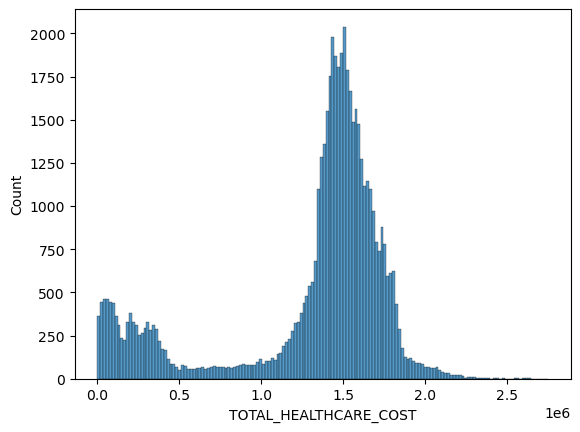

In [38]:
#plot histogram of total healthcare cost to determine distribution
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
patient_data_pdf = patient_data.toPandas()

sns.histplot(data = patient_data_pdf, x = 'TOTAL_HEALTHCARE_COST')
plt.show()

In [39]:
#due to bimodal distribution and slight skew, we can use median as a cutoff value for high/low cost categorization
#calculate median
total_cost_median = patient_data_pdf['TOTAL_HEALTHCARE_COST'].median()

print(total_cost_median)

1464225.945


In [40]:
#create high/low cost categorization column in patient_data set
from pyspark.sql.functions import when
final_data = final_data.withColumn('High_Cost', when(col('TOTAL_HEALTHCARE_COST')>total_cost_median, 1).otherwise(0))

final_data.show(5)

+--------------------+-----+-----------+------+-------------------+-------------------+---------------------+----------------+-------------+-----------------+----------------+----------------+-----------------+-----------------+---------------+------------+-------------+------------------+---------+--------------------+------------------+------------------+-----------------+------------------+------------------+------------------+-----------------------------------------------------------------------+----------------------------------------+-------------------------------------------------------------------+-------------------------------------------------------------------------+------------------------------------------------+----------------------------------------------------+--------------------------------------------+------------------+------------------+------------------+------------------+---------------------------------------------------+-----------------+------------------

### Index / OHE string columns

In [41]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder

#index gender, race, ethnicity columns
indexer_race = StringIndexer(inputCol= 'RACE', outputCol= 'RACE_INDEX')
final_data_indexed = indexer_race.fit(final_data).transform(final_data)

indexer_ethnicity = StringIndexer(inputCol= 'ETHNICITY', outputCol='ETHNICITY_INDEX')
final_data_indexed = indexer_ethnicity.fit(final_data_indexed).transform(final_data_indexed)

indexer_gender = StringIndexer(inputCol= 'GENDER', outputCol= 'GENDER_INDEX')
final_data_indexed = indexer_gender.fit(final_data_indexed).transform(final_data_indexed)

#apply OHE to indexed columns
encoder_race = OneHotEncoder(inputCol="RACE_INDEX", outputCol="RACE_OHE")
final_data_encoded = encoder_race.fit(final_data_indexed).transform(final_data_indexed)

encoder_ethnicity = OneHotEncoder(inputCol="ETHNICITY_INDEX", outputCol="ETHNICITY_OHE")
final_data_encoded = encoder_ethnicity.fit(final_data_encoded).transform(final_data_encoded)

encoder_gender = OneHotEncoder(inputCol="GENDER_INDEX", outputCol="GENDER_OHE")
final_data_encoded = encoder_gender.fit(final_data_encoded).transform(final_data_encoded)


final_data_encoded.show(5)

+--------------------+-----+-----------+------+-------------------+-------------------+---------------------+----------------+-------------+-----------------+----------------+----------------+-----------------+-----------------+---------------+------------+-------------+------------------+---------+--------------------+------------------+------------------+-----------------+------------------+------------------+------------------+-----------------------------------------------------------------------+----------------------------------------+-------------------------------------------------------------------+-------------------------------------------------------------------------+------------------------------------------------+----------------------------------------------------+--------------------------------------------+------------------+------------------+------------------+------------------+---------------------------------------------------+-----------------+------------------

In [42]:
#remove unnecessary columns
final_data_encoded = final_data_encoded.drop(*
                                             ['Id',
                                              'RACE',
                                              'ETHNICITY',
                                              'GENDER',
                                              'PATIENT', 
                                              'RACE_INDEX',
                                              'GENDER_INDEX', 
                                              'ETHNICITY_INDEX',
                                              'HEALTHCARE_EXPENSES',
                                              'HEALTHCARE_COVERAGE',
                                              'TOTAL_HEALTHCARE_COST'
                                              ])

final_data_encoded.show(5)

+----------------+-------------+-----------------+----------------+----------------+-----------------+-----------------+---------------+------------+-------------+------------------+---------+------------------+------------------+-----------------+------------------+------------------+------------------+-----------------------------------------------------------------------+----------------------------------------+-------------------------------------------------------------------+-------------------------------------------------------------------------+------------------------------------------------+----------------------------------------------------+--------------------------------------------+------------------+------------------+------------------+------------------+---------------------------------------------------+-----------------+----------------------------------------+------------------+-------------------------------------------------------+-------------------------------

### Condense data into one column with Vector Assembler

In [43]:
#use vector assembler to combine columns into one
from pyspark.ml.feature import VectorAssembler

feature_cols = [col for col in final_data_encoded.columns if col not in ['High_Cost']]

#apply vector assembler
assmebler = VectorAssembler(inputCols=feature_cols, outputCol='features')
final_data_assembled = assmebler.transform(final_data_encoded)

final_data_assembled.select('features', 'High_Cost').show(truncate = False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# Build ML Models

### Random Forest Model

In [44]:
#split data into training and testing sets

train_set, test_set = final_data_assembled.randomSplit([0.8,0.2], seed = 42)

In [45]:
#Build Random Forest Model
from pyspark.ml.classification import RandomForestClassifier

RF = RandomForestClassifier(labelCol='High_Cost', featuresCol='features', numTrees=300)

#train model
RF_model = RF.fit(train_set)

#test model
RF_test = RF_model.transform(test_set)

RF_test.select('features', 'High_Cost','prediction').show(10)




+--------------------+---------+----------+
|            features|High_Cost|prediction|
+--------------------+---------+----------+
|[1.0,0.0,0.0,1.0,...|        0|       0.0|
|[2.0,0.0,0.0,1.0,...|        0|       0.0|
|[2.0,0.0,0.0,1.0,...|        0|       0.0|
|[2.0,0.0,1.0,0.0,...|        0|       0.0|
|[2.0,0.0,1.0,1.0,...|        0|       0.0|
|[2.0,0.0,2.0,0.0,...|        1|       1.0|
|[2.0,0.0,4.0,0.0,...|        0|       1.0|
|[3.0,0.0,0.0,1.0,...|        0|       0.0|
|[3.0,0.0,1.0,0.0,...|        0|       0.0|
|[3.0,0.0,1.0,0.0,...|        0|       0.0|
+--------------------+---------+----------+
only showing top 10 rows



In [46]:
#evaluate model
import pyspark.ml.evaluation as ev

RF_evaluator  = ev.BinaryClassificationEvaluator(
    rawPredictionCol='probability',
    labelCol='High_Cost'
)

RF_AUROC = RF_evaluator.evaluate(RF_test, {RF_evaluator.metricName: 'areaUnderROC'})

print('RF_AUROC =',RF_AUROC)

RF_AUROC = 0.7234944648100531


### Gradient-Boosted Trees Model

In [47]:
#Build GBT Model
from pyspark.ml.classification import GBTClassifier

gbt = GBTClassifier(labelCol='High_Cost', featuresCol='features')

#train model
gbt_model = gbt.fit(train_set)

#Test model
gbt_test = gbt_model.transform(test_set)

gbt_test.select('features', 'High_Cost','prediction').show(10)


+--------------------+---------+----------+
|            features|High_Cost|prediction|
+--------------------+---------+----------+
|[1.0,0.0,0.0,1.0,...|        0|       0.0|
|[2.0,0.0,0.0,1.0,...|        0|       0.0|
|[2.0,0.0,0.0,1.0,...|        0|       0.0|
|[2.0,0.0,1.0,0.0,...|        0|       0.0|
|[2.0,0.0,1.0,1.0,...|        0|       0.0|
|[2.0,0.0,2.0,0.0,...|        1|       1.0|
|[2.0,0.0,4.0,0.0,...|        0|       1.0|
|[3.0,0.0,0.0,1.0,...|        0|       0.0|
|[3.0,0.0,1.0,0.0,...|        0|       0.0|
|[3.0,0.0,1.0,0.0,...|        0|       0.0|
+--------------------+---------+----------+
only showing top 10 rows



In [48]:
#evaluate model

GBT_evaluator  = ev.BinaryClassificationEvaluator(
    rawPredictionCol='probability',
    labelCol='High_Cost'
)

GBT_AUROC = GBT_evaluator.evaluate(gbt_test, {GBT_evaluator.metricName: 'areaUnderROC'})

print('GBT_AUROC =',GBT_AUROC)

GBT_AUROC = 0.7364753515347158


### Logistic Regression Model

In [ ]:
#Build Model
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(labelCol='High_Cost', featuresCol='features')

#Train Model
lr_model = lr.fit(train_set)

#Test Model
lr_test = lr_model.transform(test_set)

lr_test.select('features', 'High_Cost','prediction').show(10)

ERROR:root:KeyboardInterrupt while sending command.][Stage 6881:> (0 + 0) / 1]4]
Traceback (most recent call last):
  File "/opt/anaconda3/envs/bmi6318/lib/python3.10/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/opt/anaconda3/envs/bmi6318/lib/python3.10/site-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/opt/anaconda3/envs/bmi6318/lib/python3.10/socket.py", line 705, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt


KeyboardInterrupt: 

25/08/01 19:47:40 ERROR Inbox: Ignoring error                       (1 + 3) / 4]
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apach

In [ ]:
#evaluate model
lr_evaluator  = ev.BinaryClassificationEvaluator(
    rawPredictionCol='probability',
    labelCol='High_Cost'
)

LR_AUROC = lr_evaluator.evaluate(lr_test, {lr_evaluator.metricName: 'areaUnderROC'})


print('LR_AUROC =',LR_AUROC)

25/04/17 13:00:04 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/17 13:00:05 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/17 13:00:05 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/17 13:00:05 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/17 13:00:08 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/17 13:00:09 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/17 13:00:09 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/17 13:00:09 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


LR_AUROC = 0.723664934070143


### Model AUROC Comparisons

In [ ]:
print('LR_AUROC =',LR_AUROC)
print('GBT_AUROC =',GBT_AUROC)
print('RF_AUROC =',RF_AUROC)

LR_AUROC = 0.723664934070143
GBT_AUROC = 0.7349903339351824
RF_AUROC = 0.7219558826211449
